In [1]:
import pandas as pd
import seaborn as sns



In [2]:
tlc = pd.read_parquet("/Users/jiang/Desktop/fhvhv_tripdata_2024-01.parquet", engine='pyarrow')

In [3]:
pickUpID = tlc['PULocationID']
dropOffID = tlc['DOLocationID']

In [4]:
tlc_nta = pd.read_csv("taxi-zone-lookup-with-ntacode.csv")

In [5]:
pu_df = tlc.merge(tlc_nta, how="left", left_on='PULocationID', right_on="location_id")
do_df = tlc.merge(tlc_nta, how="left", left_on='DOLocationID', right_on="location_id")

In [6]:
nta = pd.read_csv("Neighborhood_Cleaned.csv")

In [7]:
# Changes all elements in column '% Other' to be floats by removing the % symbol
nta['% Other'] = nta["% Other"].str[:-1].astype(float)

In [8]:
mrgd = tlc.merge(tlc_nta, how="left", left_on='PULocationID', right_on="location_id", suffixes=(None, "PU"))
mrgd = mrgd.merge(tlc_nta, how="left", left_on='DOLocationID', right_on="location_id", suffixes=(None, "DO"))

In [9]:
mrgd = mrgd.merge(nta, how="left", left_on='ntacode', right_on="NTA Code", suffixes=(None, "PU"))
mrgd = mrgd.merge(nta, how="left", left_on='ntacodeDO', right_on="NTA Code", suffixes=(None, "DO"))

In [10]:
mrgd.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'location_id', 'borough', 'zone',
       'service_zone', 'ntacode', 'location_idDO', 'boroughDO', 'zoneDO',
       'service_zoneDO', 'ntacodeDO',
       'Neighborhood Tabulation Area (NTA) Name', 'NTA Code', 'Boro Name',
       'Boro CD', 'Total Population', '65+ years', '%65+ yeras',
       '%65+ Below poverty', '% Hispanic/Latino', '% White',
       '% Black/African American', '% Asian', '% Other',
       'Neighborhood Tabulation Area (NTA) NameDO', 'NTA CodeDO',
       'Boro NameDO', 'Boro CDDO', 'Total PopulationDO',

In [11]:
mrgd = mrgd.drop(columns=['dispatching_base_num', 'originating_base_num',\
                          'location_id', 'service_zone', 'ntacode',\
                          'location_idDO', 'service_zoneDO', 'ntacodeDO',\
                          'NTA Code', 'NTA CodeDO'])

In [12]:
mrgd = mrgd.rename(columns={'hvfhs_license_num': 'Ride-Hailing Service Number',\
                            'request_datetime': 'Request Datetime',\
                            'on_scene_datetime': 'On-Scene Datetime',\
                            'pickup_datetime': 'Pick-Up Datetime',\
                            'dropoff_datetime': 'Drop-Off Datetime',\
                            'PULocationID': 'Pick-Up Location ID',\
                            'DOLocationID': 'Drop-Off Location ID',\
                            'trip_miles': 'Trip Distance (miles)',\
                            'trip_time': 'Trip Length (seconds)',\
                            'base_passenger_fare': 'Base Passenger Fare',\
                            'tolls': 'Toll Fare',\
                            'bcf': 'Black Car Fund Fare',\
                            'sales_tax': 'NYS Sales Tax Fare',\
                            'congestion_surcharge': 'NYS Congestion Surcharge',\
                            'airport_fee': 'Airport Fee',\
                            'tips': 'Tips Given',\
                            'driver_pay': 'Driver Pay',\
                            'shared_request_flag': 'Passenger Agreed to Share Ride', \
                            'shared_match_flag': 'Passenger Shared Ride',\
                            'access_a_ride_flag': 'Administered by MTA',\
                            'wav_request_flag': 'Passenger Requested WAV',\
                            'wav_match_flag': 'Passenger Rode in WAV'})


In [13]:
mrgd.columns

Index(['Ride-Hailing Service Number', 'Request Datetime', 'On-Scene Datetime',
       'Pick-Up Datetime', 'Drop-Off Datetime', 'Pick-Up Location ID',
       'Drop-Off Location ID', 'Trip Distance (miles)',
       'Trip Length (seconds)', 'Base Passenger Fare', 'Toll Fare',
       'Black Car Fund Fare', 'NYS Sales Tax Fare', 'NYS Congestion Surcharge',
       'Airport Fee', 'Tips Given', 'Driver Pay',
       'Passenger Agreed to Share Ride', 'Passenger Shared Ride',
       'Administered by MTA', 'Passenger Requested WAV',
       'Passenger Rode in WAV', 'borough', 'zone', 'boroughDO', 'zoneDO',
       'Neighborhood Tabulation Area (NTA) Name', 'Boro Name', 'Boro CD',
       'Total Population', '65+ years', '%65+ yeras', '%65+ Below poverty',
       '% Hispanic/Latino', '% White', '% Black/African American', '% Asian',
       '% Other', 'Neighborhood Tabulation Area (NTA) NameDO', 'Boro NameDO',
       'Boro CDDO', 'Total PopulationDO', '65+ yearsDO', '%65+ yerasDO',
       '%65+ Below p

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.metrics import accuracy_score

In [15]:
# 1. data preprocessing
mrgd_copy = mrgd

# drop rows with missing values
mrgd_copy = mrgd_copy.dropna()

# binary target
# classify a ride as “high fare” if Base Passenger Fare > the median.
fare_median = mrgd_copy['Base Passenger Fare'].median()
mrgd_copy['high_fare'] = (mrgd_copy['Base Passenger Fare'] > fare_median).astype(int)

# protected attribute.
# create a binary attribute: 1 if the value is above the median, 0 otherwise.
eth_median = mrgd_copy['% Black/African American'].median()
mrgd_copy['protected_black'] = (mrgd_copy['% Black/African American'] > eth_median).astype(int)

#eth_hispanic_median = mrgd_copy['% Hispanic/Latino'].median()
#mrgd_copy['protected_hispanic'] = (mrgd_copy['% Hispanic/Latino'] > eth_hispanic_median).astype(int)

#eth_hispanic_median = mrgd_copy['% Asian'].median()
#mrgd_copy['protected_asian'] = (mrgd_copy['% Asian/Latino'] > eth_asian_median).astype(int)


#  "Trip Distance (miles)" and "Trip Length (seconds)" as features
features = ['Trip Distance (miles)', 'Trip Length (seconds)']
X = mrgd_copy[features]
y = mrgd_copy['high_fare']
A = mrgd_copy['protected_black']

# split the data into training and test sets
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.3, random_state=42, stratify=y
)


/var/folders/1v/jgwmbyqx15scf95nddcnzm040000gn/T/ipykernel_80171/1828435090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrgd_copy['high_fare'] = (mrgd_copy['Base Passenger Fare'] > fare_median).astype(int)
/var/folders/1v/jgwmbyqx15scf95nddcnzm040000gn/T/ipykernel_80171/1828435090.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrgd_copy['protected_black'] = (mrgd_copy['% Black/African American'] > eth_median).astype(int)


In [16]:
#2. baseline
print("=== Baseline Logistic Regression Model ===")
baseline_clf = LogisticRegression(solver='liblinear')
baseline_clf.fit(X_train, y_train)

# predict test set
y_pred_baseline = baseline_clf.predict(X_test)

acc_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {acc_baseline:.3f}")

# compute error rates per group (False Positive and False Negative rates)
def compute_error_rates(y_true, y_pred, sensitive):
    groups = np.unique(sensitive)
    rates = {}
    for g in groups:
        mask = (sensitive == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred[mask]
        tp = np.sum((y_true_g == 1) & (y_pred_g == 1))
        tn = np.sum((y_true_g == 0) & (y_pred_g == 0))
        fp = np.sum((y_true_g == 0) & (y_pred_g == 1))
        fn = np.sum((y_true_g == 1) & (y_pred_g == 0))
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        rates[g] = {'FPR': fpr, 'FNR': fnr}
    return rates

baseline_rates = compute_error_rates(y_test.values, y_pred_baseline, A_test.values)
print("Baseline Error Rates by Protected Group (0: lower, 1: higher '% Black'):")
for group, rates in baseline_rates.items():
    print(f"  Group {group}: FPR = {rates['FPR']:.3f}, FNR = {rates['FNR']:.3f}")


=== Baseline Logistic Regression Model ===
Baseline Accuracy: 0.878
Baseline Error Rates by Protected Group (0: lower, 1: higher '% Black'):
  Group 0: FPR = 0.072, FNR = 0.198
  Group 1: FPR = 0.122, FNR = 0.080


Baseline Model
Overall Accuracy: 87.8%

Error Rates by Protected Group:
Group 0 (Lower '% Black'):
False Positive Rate (FPR): 7.2%
False Negative Rate (FNR): 19.8%
Group 1 (Higher '% Black'):
FPR: 12.2%
FNR: 8.0%

The baseline model has a noticeable disparity between groups:
FPR Disparity: Group 1 experiences a higher FPR compared to Group 0, meaning that members of Group 1 are more likely to be incorrectly classified as having a “high fare” when they actually do not.
FNR Disparity: Conversely, Group 0 has a higher FNR, meaning they are more likely to be incorrectly classified as “low fare” when they should be “high fare.”
This imbalance suggests that the model might be favoring one group over the other in terms of the types of errors it makes.

In [17]:
#3. fairness-aware mitigation with equalized odds
print("\n=== Fairness-Aware Model (Equalized Odds via ExponentiatedGradient) ===")
# Set fairness constraint

constraint = EqualizedOdds()

# exponentiatedGradient to enforce constraints
fair_clf = ExponentiatedGradient(
    estimator=LogisticRegression(solver='liblinear'),
    constraints=constraint,
    eps=0.01  #play around
)

# fit fairness-aware model
fair_clf.fit(X_train, y_train, sensitive_features=A_train)

y_pred_fair = fair_clf.predict(X_test)
acc_fair = accuracy_score(y_test, y_pred_fair)
print(f"Fair Model Accuracy: {acc_fair:.3f}")

# analysis
fair_rates = compute_error_rates(y_test.values, y_pred_fair, A_test.values)
print("Fair Model Error Rates by Protected Group:")
for group, rates in fair_rates.items():
    print(f"  Group {group}: FPR = {rates['FPR']:.3f}, FNR = {rates['FNR']:.3f}")


=== Fairness-Aware Model (Equalized Odds via ExponentiatedGradient) ===
Fair Model Accuracy: 0.766
Fair Model Error Rates by Protected Group:
  Group 0: FPR = 0.178, FNR = 0.299
  Group 1: FPR = 0.176, FNR = 0.282


Fairness vs. Accuracy Trade-Off:

Baseline Model: High accuracy but unequal error distribution between groups.

Fairness-Aware Model: Lower overall accuracy but much more balanced error rates across groups.

Implications for Price Discrimination Bias:

If the goal is to mitigate price discrimination bias, equalizing error rates (i.e., ensuring that neither group is disproportionately misclassified) may be more important than achieving the highest possible accuracy.
The fairness-aware model ensures that neither group is unfairly burdened by a higher rate of false positives or false negatives, which is a step toward reducing bias in decision-making.

# VVV ExponentiatedGradient for more bias mitigation (didnt make a difference) VVV

In [18]:
mrgd_test = mrgd
mrgd_test = mrgd_test.dropna()

fare_median = mrgd_test['Base Passenger Fare'].median()
mrgd_test['high_fare'] = (mrgd_test['Base Passenger Fare'] > fare_median).astype(int)

eth_median = mrgd_test['% Black/African American'].median()
mrgd_test['protected_black'] = (mrgd_test['% Black/African American'] > eth_median).astype(int)


features = ['Trip Distance (miles)', 'Trip Length (seconds)']
X = mrgd_test[features]
y = mrgd_test['high_fare']
A = mrgd_test['protected_black']  # Protected attribute
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.3, random_state=42, stratify=y
)
constraint = EqualizedOdds()
base_estimator = LogisticRegression(solver='liblinear')

# ExponentiatedGradient
# The 'eps' parameter sets the tolerance for constraint violations.
fair_clf = ExponentiatedGradient(estimator=base_estimator, constraints=constraint, eps=0.01)

fair_clf.fit(X_train, y_train, sensitive_features=A_train)
y_pred_fair = fair_clf.predict(X_test)
accuracy_fair = accuracy_score(y_test, y_pred_fair)
print(f"Fair Model Accuracy: {accuracy_fair:.3f}")
def compute_error_rates(y_true, y_pred, sensitive):
    groups = np.unique(sensitive)
    rates = {}
    for g in groups:
        mask = (sensitive == g)
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        tp = np.sum((y_true_group == 1) & (y_pred_group == 1))
        tn = np.sum((y_true_group == 0) & (y_pred_group == 0))
        fp = np.sum((y_true_group == 0) & (y_pred_group == 1))
        fn = np.sum((y_true_group == 1) & (y_pred_group == 0))
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        rates[g] = {'FPR': fpr, 'FNR': fnr}
    return rates

fair_error_rates = compute_error_rates(y_test.values, y_pred_fair, A_test.values)
print("Fair Model Error Rates by Protected Group:")
for group, metrics in fair_error_rates.items():
    print(f"  Group {group}: FPR = {metrics['FPR']:.3f}, FNR = {metrics['FNR']:.3f}")


/var/folders/1v/jgwmbyqx15scf95nddcnzm040000gn/T/ipykernel_80171/1229141784.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrgd_test['high_fare'] = (mrgd_test['Base Passenger Fare'] > fare_median).astype(int)
/var/folders/1v/jgwmbyqx15scf95nddcnzm040000gn/T/ipykernel_80171/1229141784.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrgd_test['protected_black'] = (mrgd_test['% Black/African American'] > eth_median).astype(int)


Fair Model Accuracy: 0.766
Fair Model Error Rates by Protected Group:
  Group 0: FPR = 0.178, FNR = 0.299
  Group 1: FPR = 0.176, FNR = 0.281


The overall accuracy has dropped to 76.6% from what might have been a higher baseline accuracy (typically seen when no fairness constraints are applied). This is a common trade-off: by enforcing fairness (i.e., equalizing error rates), the model sacrifices some predictive performance.

classifier is used to predict whether a ride's fare is "high" or "low"—the error metrics are defined as:

False Positive Rate (FPR):
low-fare (negative cases) but are incorrectly predicted as high-fare (positive cases). COMPARE the FPR across different groups (neighborhoods with higher versus lower percentages of Black residents) helps identify if one group is more likely to be wrongly charged a high fare.

False Negative Rate (FNR):
Actually high-fare (positive cases) but are incorrectly predicted as low-fare (negative cases). Compare FNR across groups and if one group is more likely to be undercharged when they should be classified as high-fare.
If one group shows a significantly higher FPR or FNR, it would indicate that the model is biased against that group.

# VVVV IGNORE FOR NOW (dont run) VVVV

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds


Evaluating for protected attribute: Black (protected_black)
Baseline Accuracy: 0.878
Fair Model Accuracy: 0.766

Evaluating for protected attribute: Hispanic (protected_hispanic)
Baseline Accuracy: 0.878
Fair Model Accuracy: 0.780

Evaluating for protected attribute: White (protected_white)
Baseline Accuracy: 0.878
Fair Model Accuracy: 0.778

Evaluating for protected attribute: Asian (protected_asian)
Baseline Accuracy: 0.878
Fair Model Accuracy: 0.693

Evaluating for protected attribute: Other (protected_other)
Baseline Accuracy: 0.878
Fair Model Accuracy: 0.815

Comparison of Error Disparities and Accuracies:
  Ethnicity           Model  FPR_Disparity  FNR_Disparity  Accuracy
0     Black        Baseline       0.049385       0.118028  0.877918
1     Black  Fairness-Aware       0.000668       0.016883  0.765675
2  Hispanic        Baseline       0.047129       0.133224  0.877918
3  Hispanic  Fairness-Aware       0.012678       0.018273  0.779683
4     White        Baseline       0.0539

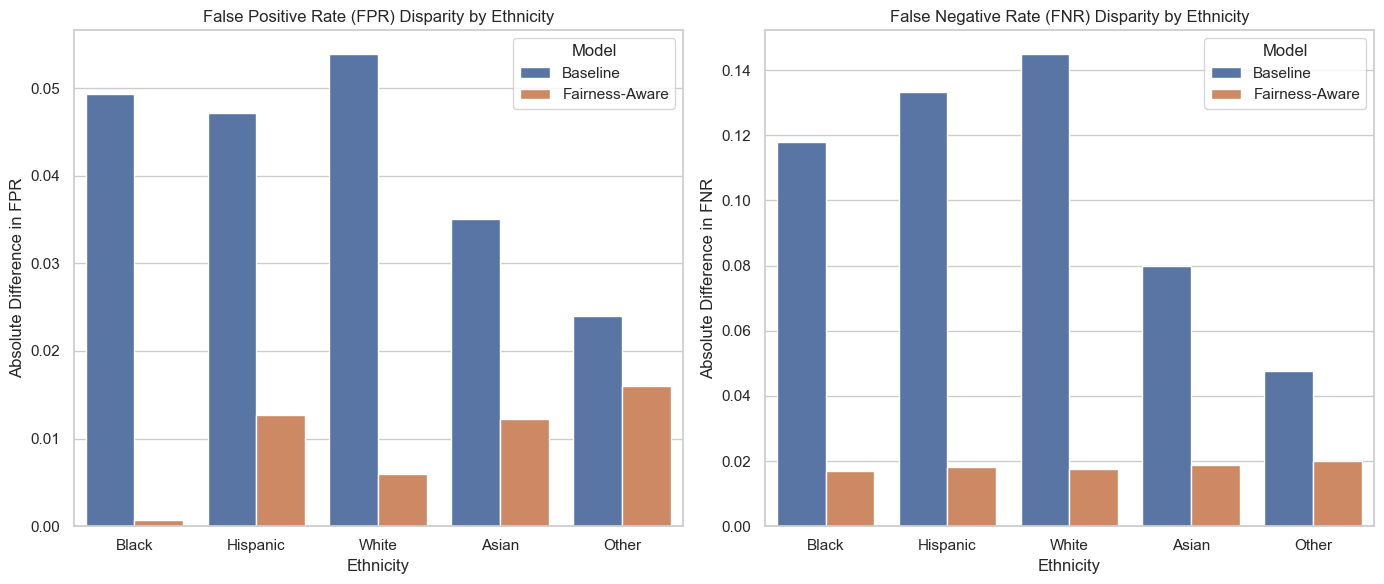

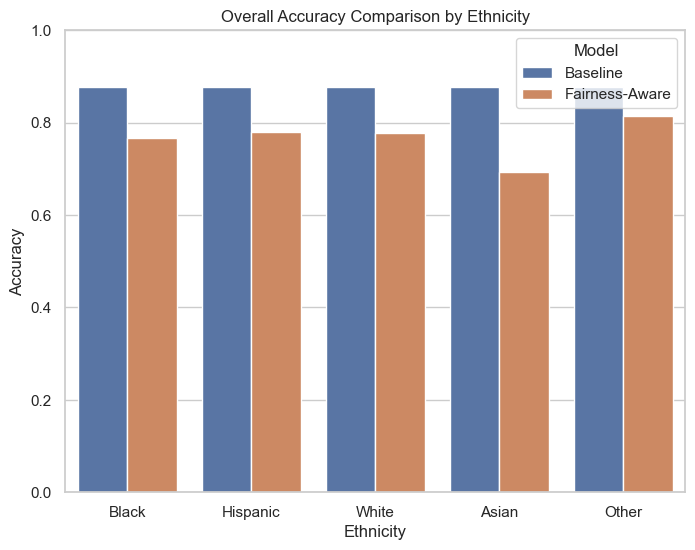

In [20]:
# 1. Load and Preprocess the Data


mrgd = mrgd.dropna()
fare_median = mrgd['Base Passenger Fare'].median()
mrgd['high_fare'] = (mrgd['Base Passenger Fare'] > fare_median).astype(int)

features = ['Trip Distance (miles)', 'Trip Length (seconds)']

ethnicities = {
    'Black': '% Black/African American',
    'Hispanic': '% Hispanic/Latino',
    'White': '% White',
    'Asian': '% Asian',
    'Other': '% Other'
}

for eth, col in ethnicities.items():
    median_val = mrgd[col].median()
    mrgd[f'protected_{eth.lower()}'] = (mrgd[col] > median_val).astype(int)

def compute_error_rates(y_true, y_pred, sensitive):
    """
    Computes the False Positive Rate (FPR) and False Negative Rate (FNR)
    for each subgroup defined by the sensitive attribute.
    Returns a dictionary with keys for each group (e.g., 0 and 1).
    """
    groups = np.unique(sensitive)
    rates = {}
    for g in groups:
        mask = (sensitive == g)
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        tp = np.sum((y_true_group == 1) & (y_pred_group == 1))
        tn = np.sum((y_true_group == 0) & (y_pred_group == 0))
        fp = np.sum((y_true_group == 0) & (y_pred_group == 1))
        fn = np.sum((y_true_group == 1) & (y_pred_group == 0))
        # Avoid division by zero
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        rates[g] = {'FPR': fpr, 'FNR': fnr}
    return rates

results = []

for eth, col in ethnicities.items():
    sens_col = f'protected_{eth.lower()}'
    print(f"\nEvaluating for protected attribute: {eth} ({sens_col})")
    
    X = mrgd[features]
    y = mrgd['high_fare']
    A = mrgd[sens_col]
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
        X, y, A, test_size=0.3, random_state=42, stratify=y
    )
    
    # ----- Baseline Model -----
    baseline_clf = LogisticRegression(solver='liblinear')
    baseline_clf.fit(X_train, y_train)
    y_pred_baseline = baseline_clf.predict(X_test)

    baseline_acc = accuracy_score(y_test, y_pred_baseline)
    print(f"Baseline Accuracy: {baseline_acc:.3f}")
    
    baseline_rates = compute_error_rates(y_test.values, y_pred_baseline, A_test.values)
    baseline_fpr_disp = abs(baseline_rates[0]['FPR'] - baseline_rates[1]['FPR'])
    baseline_fnr_disp = abs(baseline_rates[0]['FNR'] - baseline_rates[1]['FNR'])
    
    results.append({
        'Ethnicity': eth,
        'Model': 'Baseline',
        'FPR_Disparity': baseline_fpr_disp,
        'FNR_Disparity': baseline_fnr_disp,
        'Accuracy': baseline_acc
    })
    
    # ----- Fairness-Aware Model (ExponentiatedGradient with Equalized Odds) -----
    constraint = EqualizedOdds()
    fair_clf = ExponentiatedGradient(
        estimator=LogisticRegression(solver='liblinear'),
        constraints=constraint,
        eps=0.01  # Adjust as needed
    )
    fair_clf.fit(X_train, y_train, sensitive_features=A_train)
    y_pred_fair = fair_clf.predict(X_test)
    
    fair_acc = accuracy_score(y_test, y_pred_fair)
    print(f"Fair Model Accuracy: {fair_acc:.3f}")
    
    fair_rates = compute_error_rates(y_test.values, y_pred_fair, A_test.values)
    fair_fpr_disp = abs(fair_rates[0]['FPR'] - fair_rates[1]['FPR'])
    fair_fnr_disp = abs(fair_rates[0]['FNR'] - fair_rates[1]['FNR'])
    
    results.append({
        'Ethnicity': eth,
        'Model': 'Fairness-Aware',
        'FPR_Disparity': fair_fpr_disp,
        'FNR_Disparity': fair_fnr_disp,
        'Accuracy': fair_acc
    })

results_df = pd.DataFrame(results)
print("\nComparison of Error Disparities and Accuracies:")
print(results_df)

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(
    data=results_df,
    x='Ethnicity',
    y='FPR_Disparity',
    hue='Model',
    ax=axes[0]
)
axes[0].set_title('False Positive Rate (FPR) Disparity by Ethnicity')
axes[0].set_ylabel('Absolute Difference in FPR')
axes[0].set_xlabel('Ethnicity')

sns.barplot(
    data=results_df,
    x='Ethnicity',
    y='FNR_Disparity',
    hue='Model',
    ax=axes[1]
)
axes[1].set_title('False Negative Rate (FNR) Disparity by Ethnicity')
axes[1].set_ylabel('Absolute Difference in FNR')
axes[1].set_xlabel('Ethnicity')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x='Ethnicity',
    y='Accuracy',
    hue='Model'
)
plt.title('Overall Accuracy Comparison by Ethnicity')
plt.ylabel('Accuracy')
plt.xlabel('Ethnicity')
plt.ylim(0, 1)
plt.show()
